In [27]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
log_directory = Path(".") #/Users/andreas/workspace/thesis-code/out/exp-backup/privacy
result_files = [path for path in log_directory.iterdir() if path.suffix == ".csv" and "results_" in path.name]

dfs = []
hyperparams = []

for f in result_files:
    print(f"Loading results file \"{f.name}\"")
    dfs.append(pd.read_csv(f))

    parameters = ["devices", "epochs", "local_epochs", "local_batch_size", "clients_per_round",
                  "l2_norm_clip", "noise_multiplier", "local_dp", "start_time"]
    parameter_values = f.stem.lstrip("results_").split("_")
    assert len(parameter_values) == len(parameters)
    hyperparams.append(
        {key: value for (key, value) in zip(parameters, parameter_values)}
    )
experiments = list(zip(hyperparams, dfs))

Loading results file "results_100_150_1_10_5_0.5_0.5_True_1620570254.558681.csv"


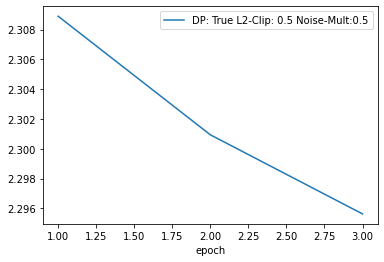

In [4]:
# Test Loss Plot
fig, ax = plt.subplots()
for params, df in experiments:
    df.plot(x="epoch", y="test_loss", ax=ax, label=f'DP: {params["local_dp"]} L2-Clip: {params["l2_norm_clip"]} Noise-Mult:{params["noise_multiplier"]}')
fig.savefig(log_directory / "test_loss.pdf")

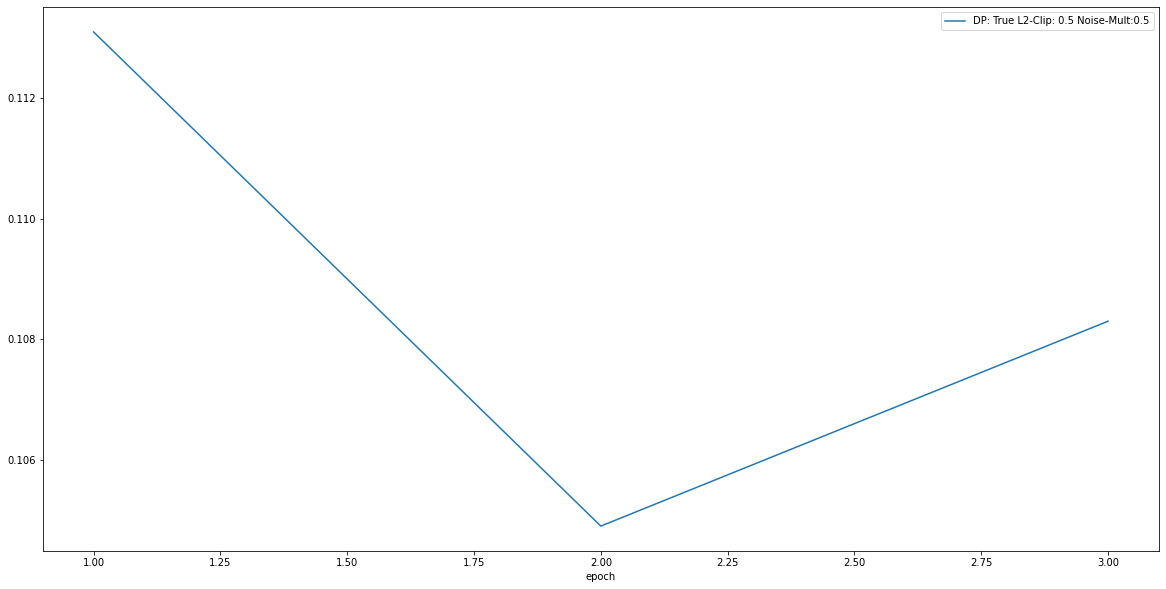

In [5]:
# Test Accuracy Plot
fig, ax = plt.subplots(figsize=(20, 10))
for params, df in experiments:
    df.plot(x="epoch", y="test_accuracy", ax=ax, label=f'DP: {params["local_dp"]} L2-Clip: {params["l2_norm_clip"]} Noise-Mult:{params["noise_multiplier"]}')
fig.savefig(log_directory / "test_accuracy.pdf")

In [8]:
dfs[0]

,Unnamed: 0,test_loss,test_accuracy,epoch,devices,epochs,local_epochs,clients_call_duration,clients_per_round,client_histories,privacy_params,privacy_guarantees
0,0,2.308898,0.1131,1,100,150,1,9.768371,5,"[{'loss': [2.30122447013855], 'accuracy': [0.1...","{""l2_norm_clip"": 0.5, ""noise_multiplier"": 0.5,...","['{""eps"": 5.886618827219601, ""delta"": 0.000879..."
1,1,2.300943,0.1049,2,100,150,1,10.709924,5,"[{'loss': [2.145141363143921], 'accuracy': [0....","{""l2_norm_clip"": 0.5, ""noise_multiplier"": 0.5,...","['{""eps"": 5.886618827219601, ""delta"": 0.000879..."
2,2,2.295634,0.1083,3,100,150,1,13.310461,5,"[{'loss': [2.256577730178833], 'accuracy': [0....","{""l2_norm_clip"": 0.5, ""noise_multiplier"": 0.5,...","['{""eps"": 5.886618827219601, ""delta"": 0.000879..."


<AxesSubplot:xlabel='privacy_params', ylabel='eps_per_round_and_client'>

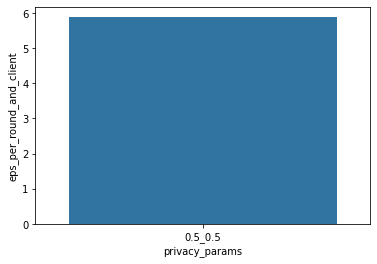

In [6]:
# Eps Guarantees
privacy_dfs = []
for params, df in [exp for exp in experiments if exp[0]["local_dp"] == "True"]:
    df = df.copy()
    df["privacy_params"] =  f'{params["l2_norm_clip"]}_{params["noise_multiplier"]}'
    df["privacy_guarantees"] = df.privacy_guarantees.map(lambda x: x.replace("'", "")).map(json.loads)
    eps_per_round_and_client = df["privacy_guarantees"][0][0]['eps']
    delta_per_round_and_client = df["privacy_guarantees"][0][0]['delta']
    df["eps_per_round_and_client"] = eps_per_round_and_client
    df["delta_per_round_and_client"] = delta_per_round_and_client
    df["eps_delta_per_round_and_client"] = f"({eps_per_round_and_client}, {delta_per_round_and_client})"
    privacy_dfs.append(df)

combined_df = pd.concat(privacy_dfs)
fig, ax = plt.subplots()
sns.barplot(x="privacy_params", y="eps_per_round_and_client", data=combined_df, ax=ax)
    #df.plot(x="epoch", y="test_accuracy", ax=ax, label=f'Clip: {params["l2_norm_clip"]} Noise:{params["noise_multiplier"]}')
#fig.savefig(log_directory / "test_accuracy.pdf")

In [7]:
eps_per_round_and_client, delta_per_round_and_client

(5.886618827219601, 0.0008790905764232305)

In [70]:
from tensorflow_privacy import get_privacy_spent
dfp = privacy_dfs[0]
dfp["rdp"] = dfp["privacy_guarantees"].map(lambda client_results: np.array(client_results[0]["rdp"]))
dfp["orders"] = dfp["privacy_guarantees"].map(lambda client_results: np.array(client_results[0]["orders"]))
dfp["delta"] = dfp["privacy_guarantees"].map(lambda client_results: client_results[0]["delta"])
dfp["rdp_cumsum"] = dfp.rdp.cumsum()
dfp["cum_privacy"] = dfp[["orders", "rdp_cumsum", "delta"]].apply(lambda row: get_privacy_spent(row[0], row[1], target_delta=row[2]), axis=1)
dfp["cum_eps"] = dfp["cum_privacy"].apply(lambda x: x[0])
dfp["cum_eps"]
#dfp.cum_privacy_guarantee_rdp = dfp.
#get_privacy_spent
#eps, _, opt_order = get_privacy_spent(orders, rdp, target_delta=delta)

0    5.886619
1    7.380470
2    8.310482
Name: cum_eps, dtype: float64

0    (5.886618827219601, 0.0008790905764232305, 2.25)
1    (7.380470395724174, 0.0008790905764232305, 2.25)
2     (8.310481855031231, 0.0008790905764232305, 2.0)
dtype: object